Store Rationalization adalah reorganisasi perusahaan untuk meningkatkan efisiensi operasi dan mengurangi biaya. akibat krisis covid-19 memfokuskan investasinya untuk membuat bisnisnya lebih digital.

kita akan menggunakan "set data Starbucks Stores" yang menyediakan lokasi semua toko yang beroperasi. kita akan memilih daerah geografi tertentu dan, selain garis lintang dan garis bukur yang disediakan, kita akan mensimulasikan beberapa informasi bisnis untuk setiap toko dalam kumpulan data (biaya, kapasitas, staf).

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import folium
import geopy

from sklearn import preprocessing, cluster
import scipy

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/mdipietro09/DataScience_ArtificialIntelligence_Utils/master/machine_learning/data_stores.csv')
df.head()

,Brand,Store Number,Store Name,Ownership Type,Street Address,City,State/Province,Country,Postcode,Phone Number,Timezone,Longitude,Latitude
0,Starbucks,47370-257954,"Meritxell, 96",Licensed,"Av. Meritxell, 96",Andorra la Vella,7,AD,AD500,376818720,GMT+1:00 Europe/Andorra,1.53,42.51
1,Starbucks,22331-212325,Ajman Drive Thru,Licensed,"1 Street 69, Al Jarf",Ajman,AJ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,55.47,25.42
2,Starbucks,47089-256771,Dana Mall,Licensed,Sheikh Khalifa Bin Zayed St.,Ajman,AJ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,55.47,25.39
3,Starbucks,22126-218024,Twofour 54,Licensed,Al Salam Street,Abu Dhabi,AZ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,54.38,24.48
4,Starbucks,17127-178586,Al Ain Tower,Licensed,"Khaldiya Area, Abu Dhabi Island",Abu Dhabi,AZ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,54.54,24.51


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25600 entries, 0 to 25599
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Brand           25600 non-null  object 
 1   Store Number    25600 non-null  object 
 2   Store Name      25600 non-null  object 
 3   Ownership Type  25600 non-null  object 
 4   Street Address  25598 non-null  object 
 5   City            25585 non-null  object 
 6   State/Province  25600 non-null  object 
 7   Country         25600 non-null  object 
 8   Postcode        24078 non-null  object 
 9   Phone Number    18739 non-null  object 
 10  Timezone        25600 non-null  object 
 11  Longitude       25599 non-null  float64
 12  Latitude        25599 non-null  float64
dtypes: float64(2), object(11)
memory usage: 2.5+ MB


In [19]:
df.City.value_counts().count()

5469

Dataset diatas memiliki lebih dari 25.000 toko dan 5.469 kota, tapi untuk studi case ini kita hanya akan menggunakan satu kota 

In [28]:
dtf = df[df['City'] == 'Las Vegas'][['City','Street Address','Longitude','Latitude']].reset_index(drop=True)
dtf = dtf.reset_index().rename(columns={'index':'id'})
dtf.head()

,id,City,Street Address,Longitude,Latitude
0,0,Las Vegas,4507 Flamingo Rd,-115.20,36.12
1,1,Las Vegas,"475 E Windmill Lane, Fashion Show",-115.15,36.04
2,2,Las Vegas,"3200 LAS VEGAS BLVD. S., STE 1795",-115.17,36.13
3,3,Las Vegas,8350 W Cheyenne Ave,-115.28,36.22
4,4,Las Vegas,3730 LAS VEGAS BLVD S,-115.18,36.11


In [29]:
dtf.count()

id                156
City              156
Street Address    156
Longitude         156
Latitude          156
dtype: int64

kawasan 'Las Vegas' terdapat 156 toko. untuk melanjutkan kasus bisnis, kita akan mensimulasikan beberapa informasi untuk setiap toko
* Potensi: total kapasitas dalam hal staf(misalnya 10 berarti toko dapat memiliki hingga 10 karyawan)
* Staf: tingkat staf saat ini (misalnya 7 berarti tokok saat ini beroperasi dengan 7 staf)
* Kapasitas: kapasitas kiri saat ini (misalnya 10-7=3, toko masih dapat menampung 3 karyawan
* Biaya: biaya tahunan bagi perusahaan untuk menjaga agar toko tetap beroperasi ('rendah','sedang','tinggi')

In [32]:
dtf['Potential'] = np.random.randint(low=3, high=10+1, size=len(dtf))
dtf['Staff'] = dtf['Potential'].apply(lambda x: int(np.random.rand()*x)+1)
dtf['Capasity'] = dtf['Potential'] - dtf['Staff']
dtf['Cost'] = np.random.choice(['Hight','Medium','Low'], size=len(dtf), p=[0.4, 0.5, 0.1])
dtf.head()

,id,City,Street Address,Longitude,Latitude,Potential,Staff,Capasity,Cost
0,0,Las Vegas,4507 Flamingo Rd,-115.20,36.12,5,2,3,Medium
1,1,Las Vegas,"475 E Windmill Lane, Fashion Show",-115.15,36.04,4,2,2,Hight
2,2,Las Vegas,"3200 LAS VEGAS BLVD. S., STE 1795",-115.17,36.13,8,7,1,Hight
3,3,Las Vegas,8350 W Cheyenne Ave,-115.28,36.22,7,4,3,Medium
4,4,Las Vegas,3730 LAS VEGAS BLVD S,-115.18,36.11,7,2,5,Medium


angka-angka diatas yang baru saja dibuat adalah simulasi data

# EDA

Anggap saja kita meiliki bisnis ritel dan kita harus menutup bebrapa toko. kita ingin melakukan itu dengan memaksimalkan keuntungan (dengan meminimalkan biaya) dan tanpa memberhentikan staff

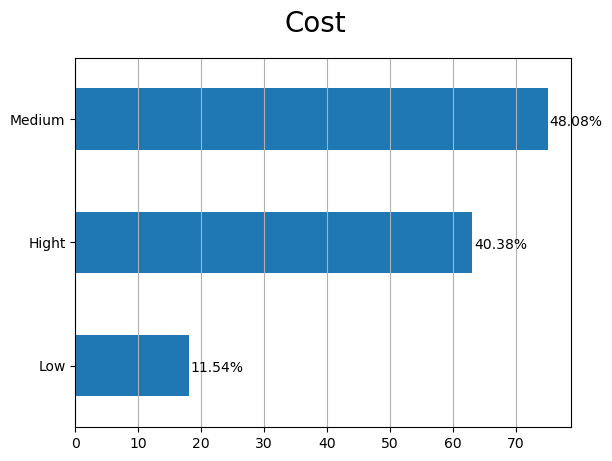

In [34]:
x='Cost'
ax = dtf[x].value_counts().sort_values().plot(kind='barh')

totals = []

for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+.20,
           str(round((i.get_width()/total)*100, 2))+'%',
           fontsize=10, color='black')
ax.grid(axis="x")
plt.suptitle(x, fontsize=20)
plt.show()

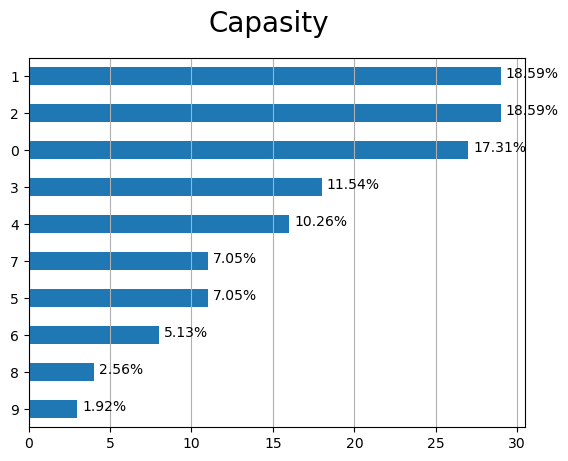

In [36]:
ax = dtf['Capasity'].value_counts().sort_values().plot(kind='barh')
totals = []

for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)

for i in ax.patches:
    ax.text(i.get_width() + .3, i.get_y()+.20,
           str(round((i.get_width()/total) * 100, 2)) + '%',
           fontsize=10, color='black')
ax.grid(axis='x')
plt.suptitle('Capasity', fontsize=20)
plt.show()

saat ini, hanya sebagian kecil toko yang beroperasi dengan potensi penuh (kapasitas kiri = 0), artinya ada beberapa dengan staff yang sangat rendah

## Visualisasi Geografi

In [39]:
city = 'Las Vegas'
# get location
locator = geopy.geocoders.Nominatim(user_agent='MyCoder')
location = locator.geocode(city)
print(location)
# keep latitude and longitude only
location = [location.latitude, location.longitude]
print('[lat, long]:',location)

Las Vegas, Clark County, Nevada, United States
[lat, long]: [36.1672559, -115.148516]


In [41]:
x, y = 'Latitude', 'Longitude'
color = 'Cost'
size = 'Staff'
popup = 'Street Address'
data = dtf.copy()

# create color column
lst_colors = ['red','greem','orange']
lst_elements = sorted(list(dtf[color].unique()))
data['color'] = data[color].apply(lambda x: lst_colors[lst_elements.index(x)])

# create size column (scaled) 
scaler = preprocessing.MinMaxScaler(feature_range=(3,15))
data['size'] = scaler.fit_transform(data[size].values.reshape(-1,1)).reshape(-1)

# initialize the map with the starting location
map_ = folium.Map(location=location, tiles='cartodbpositron', zoom_start=11)

# add points
data.apply(lambda row: folium.CircleMarker(
                       location=[row[x], row[y]],
                       popup=row[popup],
                       color=row['color'],
                       fill=True,
                       radius=row['size']).add_to(map_), axis=1)

# add html legend
legend_html = """<div style='position:fized; bottom:10px; left:10px; border:2px; solid black; z-index:9999; font-size:14px'><br>"""
map_.get_root().html.add_child(folium.Element(legend_html))

# plot the map
map_

tujuan kita adalah untuk menutup toko berbiaya tinggi(titik merah) dengan memindahkan staff ke toko biaya rendah, dengan kapasitas yang terletak di lingkungan yang sama. akibatnya, kita akan memaksimalkan keuntungan dan efisiensi

# Evaluasi dan modeling
K-means

untuk menemukan K yang tepat, kita akan menggunakan metode elbow: memplot varians sebagai fungsi dari jumlah cluster dan memilih k yang meratakan kurva

C:\Users\muhfa\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\muhfa\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\muhfa\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\muhfa\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Window

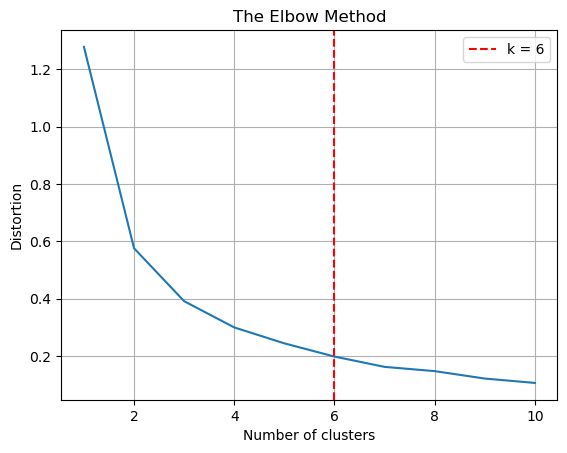

In [48]:
x = dtf[['Latitude','Longitude']]
max_k = 10

# iterations
distortions = []
for i in range(1, max_k+1):
    if len(x) >= i:
        model = cluster.KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        model.fit(x)
        distortions.append(model.inertia_)
# Best K: the lowest derivative
k = [i*100 for i in np.diff(distortions,2)].index(min([i*100 for i in np.diff(distortions,2)]))

# plot
fig, ax = plt.subplots()
ax.plot(range(1, len(distortions)+1), distortions)
ax.axvline(k, ls='--', color='red', label='k = ' + str(k))
ax.set(title='The Elbow Method', xlabel='Number of clusters', ylabel='Distortion')
ax.legend()
ax.grid(True)
plt.show()